# Advanced Computer Vision
How to map out the lane on an image of the road? 
##### Steps
 1. Camera calibration
 2. Distortion correction
 3. Color/Gradient threshold
 4. Perspective transform
 5. Detect lane lines
 6. Determine the lane curvature

### Detail of pipeline steps
**Camera Calibration**
compute the camera calibration matrix & distortion coefficients (only once).

**Distortion Correction**
apply calibrated value each new frame.

**Thresholding**
To generate a binary image where the lane lines are clearly visible. Try out various combinations of color and gradient thresholds.

**Perspective Transform**
To identify four source points for prespective transform. In this case, can assume the road is a flat plane. This isn't strictly true, but it can serve as an approximation for this task.
The easiest way to do this is to investigate an image where the lane lines are straight, and find four points lying along the lines that, after perspective transform, make the lines look straight and vertical from a bird's eye view perspective.

Those same four source points will now work to transform any image (again, under the assumption that the road is flat and the camera perspective hasn't changed).

## Finding the lines: Histogram Peaks
Now I have a thresholded warped image and ready to map out the lane lines. There are many ways, but here's one example of how I might do it.

### Line Finding Method: Peaks in a Histogram
I need to decide explicitly which pixels are part of the lines and which belong to the left line and which belong to the right line. Plotting a histgram of where the binary activations occur across the image is one potential solution for this.

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread('images/warped-example.jpg')
plt.imshow(img, cmap='gray')

In [2]:
def hist(img):
    bottom_half = img[img.shape[0]//2:, :]
    histogram = np.sum(bottom_half, axis=0)
    return histogram

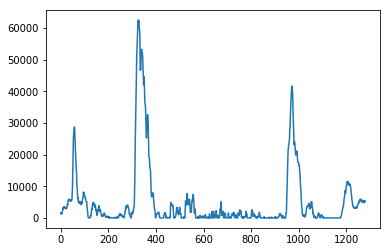

In [3]:
histogram = hist(img)
plt.plot(histogram)

## Finding the Lines: Sliding Window
The two most prominent peaks in this histogram will be good indicators of the x-position of the base of the lane lines. From that point, I can use a sliding window, placed around the line centers, to find and follow the lines up to the top of the frame.

### Split the histogram for the two lines
The first step we'll take is to split the histogram into two sides, one for each lane line.

In [4]:
histogram = np.sum(img[img.shape[0]//2:], axis=0)# an output image to draw on and visualize the result
out_img = np.dstack((img, img, img)) * 255

midpoint = histogram.shape[0]//2
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

### Set up windows and window hyperparameters
Next step is to set a few hyperparameters related to our sliding windows, and set them up to iterate across the binary activations in the image.

In [5]:
# The number of sliding windows
nwindows = 9
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix_thresh = 50

w_height = img.shape[0]//nwindows

# Identify the x and y positions of all nonzero pixels in the image
nonzero = img.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

leftx_current = leftx_base
rightx_current = rightx_base

# empty lists to recieve left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

### Iterate though nwindows to track curvature
Now that I've set up what the windows look like and have a starting point. We'll want to loop for nwindows, with the given window sliding left or right if it finds the mean position of activated pixels within the window to have shifted.

In [6]:
for i in range(nwindows):
    wy_low = img.shape[0] - (i+1) * w_height
    wy_high = wy_low + w_height
    
    wx_left_low = leftx_current - margin
    wx_left_high = leftx_current + margin
    wx_right_low = rightx_current - margin
    wx_right_high = rightx_current + margin
    
    cv2.rectangle(out_img, (wx_left_low, wy_low), (wx_left_high, wy_high), (0, 255, 0), 2)
    cv2.rectangle(out_img, (wx_right_low, wy_low), (wx_right_high, wy_high), (0, 255, 0), 2)
    
    good_left_inds = ((nonzeroy >= wy_low) & (nonzeroy < wy_high) & (nonzerox >= wx_left_low) & (nonzerox < wx_left_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= wy_low) & (nonzeroy < wy_high) & (nonzerox >= wx_right_low) & (nonzerox < wx_right_high)).nonzero()[0]
    
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    
    if len(good_left_inds) > minpix_thresh:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix_thresh:
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

### Fit a polynomial
Now that I have found all pixels belonging to each line through the sliding window method, it's time to fit a polynomial to the line.

In [7]:
try:
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
except ValueError:
    pass

leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds]
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]

In [8]:
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
try:
    left_fitx = left_fit[0] * ploty**2 + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0] * ploty**2 + right_fit[1] * ploty + right_fit[2]
except TypeError:
    print('The function failed to fit a line..')
    left_fitx = 1 * ploty ** 2 + 1 * ploty
    right_fitx = 1 * ploty ** 2 + 1 * ploty

### Visualization

(720, 0)

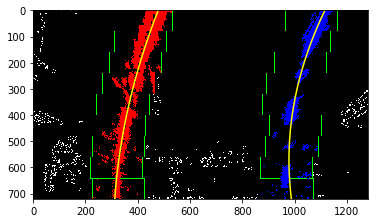

In [9]:
out_img[lefty, leftx] = [255, 0, 0]
out_img[righty, rightx] = [0, 0, 255]

plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

#### All I did above cells are packed into the functions at the cell bellow.

In [10]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2


def find_lane_pixels(binary_warped):
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    out_img = np.dstack((binary_warped, binary_warped, binary_warped)) * 255
    
    midpoint = histogram.shape[0]//2
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    nwindows = 9
    margin = 100
    minpix_thresh = 50

    window_height = binary_warped.shape[0]//nwindows
    
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    leftx_current = leftx_base
    rightx_current = rightx_base

    left_lane_inds = []
    right_lane_inds = []

    for window in range(nwindows):
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        if len(good_left_inds) > minpix_thresh:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix_thresh:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return out_img

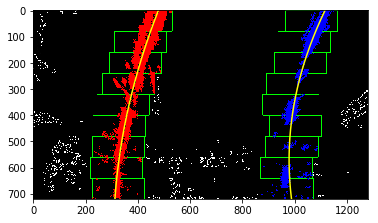

In [11]:
binary_warped = mpimg.imread('images/warped-example.jpg')
out_img = fit_polynomial(binary_warped)
plt.imshow(out_img)

## Finding the Lines: Search from Prior
I've now built an algorithm that uses sliding windows to track the lane lines. However, using the full algorithm from before and starting fresh on every frame may seem inefficient, as the lane lines don't necessarily move a lot frame to frame.

In the next frame of video I don't need to do a blind search again, but instead I can just search in a margin around the previous lane line position. So once I know where the lines are in one frame of video, I can do a highly targeted search for them in the next frame.

And that region should help me track the lanes through sharp curves and tricky conditions. If I lose track of the lines, go bagk to my sliding windows search or other method to rediscover them. Let's walk through one way to do this.

## Measuring Curvature 1


In [12]:
import numpy as np
import matplotlib.pyplot as plt


np.random.seed(0)
# Generate some fake data to represent lane-line pixels
ploty = np.linspace(0, 719, num=720)
quadratic_coeff = 3e-4 # 0.0003

# For each y position generage random x position within +/-50 pix of the line base position in each case
# (x=200 for left, and x=900 for right)
leftx = np.array([200 + y**2 * quadratic_coeff + np.random.randint(-50, high=51) for y in ploty])
rightx = np.array([900 + y**2 * quadratic_coeff + np.random.randint(-50, high=51) for y in ploty])
leftx = leftx[::-1]
rightx = rightx[::-1]

left_fit = np.polyfit(ploty, leftx, 2)
right_fit = np.polyfit(ploty, rightx, 2)

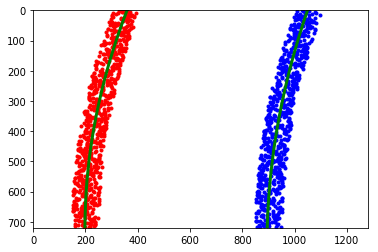

In [13]:
# Fit a second order polynomial to pixel positions in each fake lane line
left_fitx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
right_fitx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]

# Plot up the fake data
mark_size = 3
plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, ploty, color='green', linewidth=3)
plt.plot(right_fitx, ploty, color='green', linewidth=3)
plt.gca().invert_yaxis()

In [14]:
def measure_curvature_pixels(ploty, left_fit, right_fit):
    # Define y-value where I want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    left_curverad = (1 + (2*left_fit[0]*y_eval+left_fit[1])**2)**1.5 / np.absolute(2*left_fit[0])
    right_curverad = (1 + (2*right_fit[0]*y_eval+right_fit[1])**2)**1.5 / np.absolute(2*right_fit[0])
    
    return left_curverad, right_curverad

In [15]:
def generate_data():
    np.random.seed(0)
    
    ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
    quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
    
    leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                    for y in ploty])
    rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                    for y in ploty])

    leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
    rightx = rightx[::-1]  # Reverse to match top-to-bottom in y

    left_fit = np.polyfit(ploty, leftx, 2)
    right_fit = np.polyfit(ploty, rightx, 2)
    
    return ploty, left_fit, right_fit

In [16]:
ploty, left_fit, right_fit = generate_data()
left_curverad, right_curverad = measure_curvature_pixels(ploty, left_fit, right_fit)
print(left_curverad, right_curverad)

1625.0601831657232 1976.2967307714669


## Measuring Curvature 2
### From Pixels to Real-World
I've now calculated the radius of curvature for our lane lines. But I've calculated the radius of curvature based on pixel values, so the radius I am reporting is in pixel space, which is not the same as real world space. So we need actually need to repeat this calculation after converting our x and y values to real world space.

This involves measuring how long and wide the section of lane is that I'm projecting in our warped image. I could do this in detail by measuring out the physica lane in the field of view of the camera, but for this project, I can assume that if I'm projecting a section of lane similar to the images above, the lane is about 30 meters long and 3.7 meters wide. Or if I prefer to derive a conversion from pixel space to world space in my own images, compare my images with U.S. regulations that require a minimum lane width of 12 feet or 3.7 meters, and the dashed lane lines are 10 feet or 3 meters long each.

Let's say that our camera image has 720 relevant pixels in the y-dimension (remenber, my image is perspective-transformed!), and I'll say roughly 700 relevant pixels in the x-dimension (my example of fake generated data above used from 200 pixels on the left to 900 on the right, or 700). Therefore, to convert from pixels to real-world meter measurements, we can use:

    ym_per_pix = 30/720  <= meters per pixel in y dimension
    xm_per_pix = 3.7/700 <= meters per pixel in x dimension

In [17]:
import numpy as np

def generate_data(ym_per_pix, xm_per_pix):
    np.random.seed(0)
    
    ploty = np.linspace(0, 719, num=720)
    quadratic_coeff = 3e-4
    
    plotx_left = np.array([200 + (y**2) * quadratic_coeff + np.random.randint(-50, high=51) for y in ploty])
    plotx_right = np.array([900 + (y**2) * quadratic_coeff + np.random.randint(-50, high=51) for y in ploty])
    plotx_left = plotx_left[::-1]
    plotx_right = plotx_right[::-1]
    
    # Fit new polynomials to x,y in world space
    left_cr = np.polyfit(ploty * ym_per_pix, plotx_left * xm_per_pix, 2)
    right_cr = np.polyfit(ploty * ym_per_pix, plotx_right * xm_per_pix, 2)
    
    return ploty, left_cr, right_cr

def measure_curvature_real():
    ym_per_pix = 30/720
    xm_per_pix = 3.7/700
    ploty, left_cr, right_cr = generate_data(ym_per_pix, xm_per_pix)

    y_eval = np.max(ploty)
    
    left_curvarad = ((1 + (2*left_cr[0]*y_eval*ym_per_pix + left_cr[1])**2)**1.5) / np.absolute(2*left_cr[0])
    right_curvarad = ((1 + (2*right_cr[0]*y_eval*ym_per_pix + right_cr[1])**2)**1.5) / np.absolute(2*right_cr[0])
    
    return left_curvarad, right_curvarad

In [18]:
left_curvarad, right_curvarad = measure_curvature_real()
print(left_curvarad, 'm', right_curvarad, 'm')

533.7525889210931 m 648.1574851434265 m
